# Neural Network Project:  ICRL 2018 Reproducibility Challenge#
**Reproduction of the "Don't Decay the Learning Rate, Increase the Batch Size" conference paper findings by Samuel L. Smith, Pieter-Jan Kindermans, Quoc V. Le:**  https://openreview.net/pdf?id=B1Yy1BxCZ<br>
*Author: Igor Tryhub, 275235*

## Introduction

It is common practice to decay the learning rate. Authors have shown one can usually obtain the same learning curve on both training and test sets by instead increasing the batch size during training. This procedure was proved to be successful for stochastic gradient descent (SGD), SGD with momentum, Nesterov momentum, and Adam. According to the paper, it reached equivalent test accuracies after the same number of training epochs, but with fewer parameter updates, leading to greater parallelism and shorter training times. The number of parameters has been further reduced the number of parameter updates by increasing the learning rate and scaling the batch size. Among other findings, in their work they:
<ul><li> Have shown that when one decays the learning rate, one simultaneously decays the scale of random fluctuations in the SGD dynamics: decaying the learning rate is simulated annealing.
<li> Proposed an alternative procedure - instead of decaying the learning rate, they increased the batch size during training. This strategy achieved near-identical model performance on the test set with the same number of training epochs but dramatically fewer parameter updates. Their proposal does not require any fine-tuning as they follow pre-existing training schedules; when the learning rate drops by a factor of α, they instead increase the batch size by α.
<li> Could further reduce the number of parameter updates without any drop in test set accuracy by increasing the learning rate and scaling batch size to the learning rate.</ul>

## Experiment

I decided to repeat the experiment on a reduced ResNet model and applying to it SGD method from PyTorch library. I replicated the schedules for the learning rate and batch size for each of the 3 scenarios:
<ul><li> Decaying learning rate,
<li> Hybrid,
<li> Increasing batch size. </ul>

Unfortunately, due to technical limitations it was not possible to work on such numerous batch sizes as it was proposed in the paper, so I had to scale the initial value of the batch size to 200. The learning rate was set to 0.1 and the momentum of 0.9 was introduced. In the "Decaying learning rate" scenatio, the batch size was constant, while the learning rate repeatedly decaied by a factor of 5 at a sequence of 60-epoch-long "steps". "Hybrid" held the learning rate constant at the first step, instead increasing the batch size by a factor of 5. However after this first step, the batch size was constant and the learning rate decaied by a factor of 5 at each subsequent step. In the "Increasing batch size" scenario, I held the learning rate
constant throughout training, and increased the batch size by a factor of 5 at every 60-epoch-long step.

## Findings

The obtained replication results do not ideally reflect the findings of the authors of the paper, but generally they follow similar patterns, and hence prove their claims about equivalence of the effects of learning rate decay and batch size increase. Also, despite using momentum, I was not able to achieve the >90% test set accuracy of the original study, while only getting a humble ~80% result. The discrepancies in the scales of obtained effects could be explained by much smaller batch sizes as well as by the choice of a different model than described in the paper.

From the graph plotted below, it can be concluded that both learning rate decay and batch size increase lead to a rapid decrease in the cross-entropy loss and a simultaneous improvement of the test set accuracy. These effects can be clearly observed precisely at 60th and 120th epoch for all 3 scenarious. Although, in the "Decaying learning rate" scenario they are not that strong as for the scenarios which involved the update of the batch size.

For the sake of comparison, I also plotted the "vanilla case" SGD with the same initial parameters, but without any parameter update on the way. It can be seen that it strives to convergence much smoother and generally has slightly worse performance over the whole model training timeframe.

## Code

In [ ]:
%pylab inline

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.datasets as dset
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

Defining an image classifier convolutional neural network model:

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Defining an image classifier ResNet model:

In [ ]:
class BasickBlock(nn.Module):

    def __init__(self, n_in, n_out, stride=1):
        super(BasickBlock, self).__init__()
        self.connection = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(n_in, n_out, 3, stride, 1, bias=False)),
            ('norm1', nn.BatchNorm2d(n_out)),
            ('relu1', nn.ReLU(inplace=True)),
            ('conv2', nn.Conv2d(n_out, n_out, 3, 1, 1, bias=False)),
            ('norm2', nn.BatchNorm2d(n_out)),
        ]))
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(n_in, n_out, 1, stride, bias=False),
            nn.BatchNorm2d(n_out),
        )
        self.stride = stride

    def forward(self, x):
        mapping = self.connection(x)
        if self.stride != 1:
            x = self.downsample(x)
        return self.relu(mapping + x)


class ResidualBlock(nn.Module):

    def __init__(self, n_in, n_out, n_block, stride=1):
        super(ResidualBlock, self).__init__()
        self.blocks = nn.Sequential()
        self.blocks.add_module('block0', BasickBlock(n_in, n_out, stride))
        for i in range(n_block - 1):
            self.blocks.add_module('block{}'.format(i + 1), BasickBlock(n_out, n_out))

    def forward(self, x):
        return self.blocks(x)


class ResNetCifar10(nn.Module):

    def __init__(self, n_block=3):
        super(ResNetCifar10, self).__init__()
        ch = [4, 8, 16]#ch = [16, 32, 64]
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, ch[0], 3, 1, 1, bias=False)),
            ('norm1', nn.BatchNorm2d(ch[0])),
            ('relu1', nn.ReLU(inplace=True)),
            ('resb1', ResidualBlock(ch[0], ch[0], n_block)),
            ('resb2', ResidualBlock(ch[0], ch[1], n_block, 2)),
            ('resb3', ResidualBlock(ch[1], ch[2], n_block, 2)),
            ('avgpl', nn.AvgPool2d(8)),
        ]))
        self.fc = nn.Linear(ch[2], 10)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.log_softmax(x, 0)

## Defining global meta-settings and initial values of parameters

In [ ]:
net = ResNetCifar10()
N = 50000
batch_size = 1024
weight_decay=0.0005
momentum=0.9
lr=0.1
batch_scaling_coef = batch_size/lr #for future use
stat_every = 10000
epoch = 0
max_epochs = 200
acceptable_batch_size = 1024

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr, momentum, weight_decay)
history = {'train_losses': [], 'test_accuracies': []}
scenarios = {'learn_decay': 0, 'hybrid': 1, 'batch_increase': 2}
original_update_every = 60
update_every = 60
factor = 5
update_asif_original_factor = 4
update_factor = 1/(1.0/update_asif_original_factor)**(1.0/(original_update_every/update_every))
model_state_path = '/pio/scratch/2/i275235/acchybrid.checkpoint.pth.tar'

A way to save state of parameters in case kernel dies during computation:

In [ ]:
def save_checkpoint(state, filename=model_state_path):
    torch.save(state, filename)

Plotting function for the batch train loss and batch test accuracy plotting with respect to the batch number:

In [ ]:
def plot_history(history):
    figsize(16, 4)
    
    subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    semilogy(np.arange(train_loss.shape[0]), train_loss, label='Training cross-entropy')
    legend()
        
    subplot(1,2,2)
    test_accuracies = np.array(history['test_accuracies'])
    plot(np.arange(test_accuracies.shape[0]), test_accuracies, label='Test set accuracy',color='g')
    legend()
    savefig('plots_acc_hybrid.png')

Input CIFAR-10 dataset data transforming and splitting for a training and testing sets:

In [ ]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=1) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=acceptable_batch_size,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Defining parameter update at 3 different convergence scenarios

In [ ]:
def param_update(epoch, scenario, optimizer, trainloader):
    if scenario == scenarios['learn_decay']:
        if not ((epoch+1) % update_every):
            optimizer.param_groups[0]['lr'] /= factor
            
    elif scenario == scenarios['hybrid']:
        if not ((epoch+1) % update_every):
            trainloader.batch_size *= factor
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=trainloader.batch_size,
                                                shuffle=True, num_workers=1)
            if (epoch+1) >= 2*update_every:
                optimizer.param_groups[0]['lr'] /= factor
        
    elif scenario == scenarios['batch_increase']:
        if not ((epoch+1) % update_every):
            trainloader.batch_size = int(trainloader.batch_size * factor)
            trainloader = torch.utils.data.DataLoader(trainset, batch_size=trainloader.batch_size,
                                                shuffle=True, num_workers=1)
            
    return optimizer, trainloader

Training the neural network using Stochastic Gradient Descent (SGD) and measuring loss as cross-entropy:

In [ ]:
# Artificial big batch handling:

def train(epoch, scenario, optimizer, trainloader):
    net.train()
        
    optimizer, trainloader = param_update(epoch, scenario, optimizer, trainloader)
    print("Epoch: {}      batch size: {}      learning rate: {}      weight decay: {}")\
        .format(epoch+1, trainloader.batch_size, optimizer.param_groups[0]['lr'], weight_decay)

    total = 0
    errors = 0
    train_loss = 0
    processed = 0
    
    for data in trainloader:
        processed += int(data[1].size()[0])
        optimizer.zero_grad() # zero the parameter gradients
        
        #---Here is the tirck to artificially increase the batch size without additional RAM available:---
        acc_loops = ((int(data[1].size()[0]) - 1) // acceptable_batch_size) + 1
        if (epoch+1) >= update_every and scenario != scenarios['learn_decay']:
            acc_loops = factor * ((epoch+1) // update_every) #how many parts we want to split our big batch
        batch_max_size = ((int(data[1].size()[0]) - 1) // acceptable_batch_size) + 1 #how big the parts should be
        loss = 0
        
        for loop in range(acc_loops):
            inputs = data[0][loop*acceptable_batch_size : (loop+1)*acceptable_batch_size] # get partial images
            labels = data[1][loop*acceptable_batch_size : (loop+1)*acceptable_batch_size] # get partial labels
            inputs, labels = Variable(inputs), Variable(labels) # wrap them in Variable
            outputs = net.forward(inputs) # forward + backward + optimize
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=(loop==acc_loops-1))
            
        optimizer.step()
        #-------------------------------------------------------------------------------------------------

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        errors += (predicted != labels.data).sum()
        train_loss += loss.data[0]
        if (processed // stat_every):    # print loss statistics every `stat_every` processed elements
            print('\tLoss: %.3f' % (loss.data[0]))
            processed -= stat_every
            
    correct = total-errors
    train_accuracy = 100.0 * correct / total
    history['train_losses'].append(train_loss)
    print('\tAccuracy for training epoch: %.2f%%' % (train_accuracy))
    
    save_checkpoint({
        'epoch': epoch,
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'scenario' : scenario,
        'trainloader' : trainloader,
        'history' : history,
    })
    print("\tCheckpoint saved!")
    return optimizer, trainloader

In [ ]:
# Normal batch handling:

def train(epoch, scenario, optimizer, trainloader):
    net.train()
        
    optimizer, trainloader = param_update(epoch, scenario, optimizer, trainloader)
    print("Epoch: {}      batch size: {}      learning rate: {}      weight decay: {}")\
        .format(epoch+1, trainloader.batch_size, optimizer.param_groups[0]['lr'], weight_decay)

    total = 0
    errors = 0
    train_loss = 0
    processed = 0
    
    for data in trainloader:
        processed += int(data[1].size()[0])
        optimizer.zero_grad() # zero the parameter gradients
        
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels) # wrap them in Variable
        outputs = net.forward(inputs) # forward + backward + optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        errors += (predicted != labels.data).sum()
        train_loss += loss.data[0]
        if (processed // stat_every):    # print loss statistics every `stat_every` processed elements
            print('\tLoss: %.3f' % (loss.data[0]))
            processed -= stat_every
            
    correct = total-errors
    train_accuracy = 100.0 * correct / total
    history['train_losses'].append(train_loss)
    print('\tAccuracy for training epoch: %.2f%%' % (train_accuracy))
    
    save_checkpoint({
        'epoch': epoch,
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'scenario' : scenario,
        'trainloader' : trainloader,
        'history' : history,
    })
    print("\tCheckpoint saved!")
    return optimizer, trainloader

Testing the network on the test data:

In [ ]:
def test(epoch, testloader):
    net.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0
    
    for data in testloader:
        images, labels = data
        images, labels = Variable(images), Variable(labels)
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        test_loss += loss.data[0]
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
        if not((epoch+1)%5):
            c = (predicted == labels.data).squeeze()
            for i in range(int(data[1].size()[0])):
                label = labels[i]
                class_correct[label.data[0]] += c[i]
                class_total[label.data[0]] += 1
    
    test_accuracy = 100.0 * correct / total
    history['test_accuracies'].append(test_accuracy)
    print('\tAccuracy of the network on the 10000 test images: %.2f%%' % (test_accuracy))
    if not((epoch+1)%5):
        for i in range(10):
            print('\t\tFor %5s : %2d %%' % (
                classes[i], 100.0 * class_correct[i] / class_total[i]))

## Start of the program

In [ ]:
scenario = scenarios['hybrid']
epochs_num = 200

In [ ]:
for e in range(200-epoch):
    if epoch==epochs_num:
        break
    optimizer, trainloader = train(epoch, scenario, optimizer, trainloader)
    test(epoch, testloader)
    epoch+=1

In [ ]:
plot_history(history)

### CAUTION! ### 
The following cell loads last serialized parameters from memory and overwrites the current state:

In [ ]:
if os.path.isfile(model_state_path):
    checkpoint = torch.load(model_state_path)
    epoch = checkpoint['epoch'] + 1
    net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scenario = checkpoint['scenario']
    trainloader = checkpoint['trainloader']
    history = checkpoint['history']
    print("Checkpoint successfully loaded from '{}'!".format(model_state_path))

## Results visualisation

In [ ]:
folder_path = './'
vanilla_path = folder_path+'newvanilla.checkpoint.pth.tar'
decay_path = folder_path+'smalldecay.checkpoint.pth.tar'
hybrid_path = folder_path+'hybridnew.checkpoint.pth.tar'
batch_path = folder_path+'noacc.checkpoint.pth.tar'

if os.path.isfile(vanilla_path):
    checkpoint = torch.load(vanilla_path)
    vanilla_history = checkpoint['history']
    print("Vanilla checkpoint successfully loaded from '{}'!".format(vanilla_path))

if os.path.isfile(decay_path):
    checkpoint = torch.load(decay_path)
    decay_history = checkpoint['history']
    print("Decay checkpoint successfully loaded from '{}'!".format(decay_path))

if os.path.isfile(hybrid_path):
    checkpoint = torch.load(hybrid_path)
    hybrid_history = checkpoint['history']
    print("Hybrid checkpoint successfully loaded from '{}'!".format(hybrid_path))
    
if os.path.isfile(batch_path):
    checkpoint = torch.load(batch_path)
    batch_history = checkpoint['history']
    print("Batch checkpoint successfully loaded from '{}'!".format(batch_path))

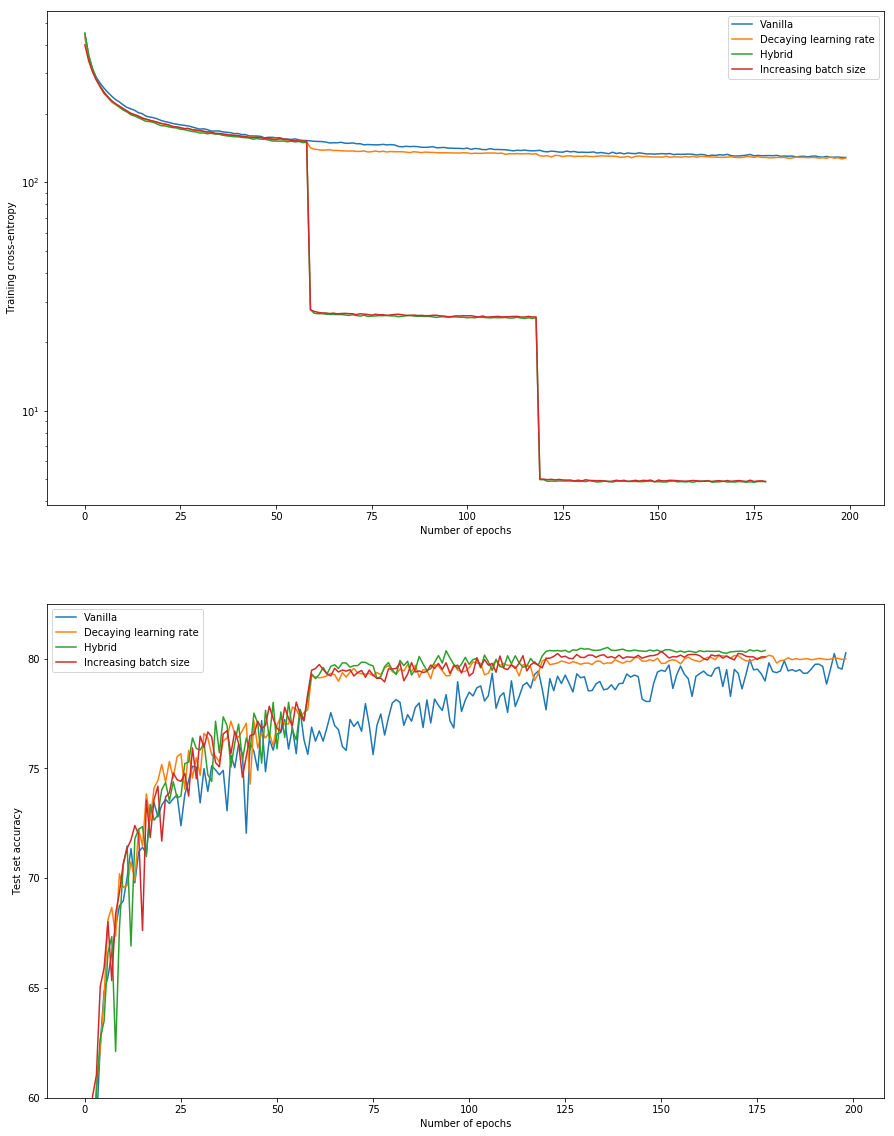

In [17]:
figsize(15, 20)
    
subplot(2,1,1)
vanilla_train_loss = np.array(vanilla_history['train_losses'])
decay_train_loss = np.array(decay_history['train_losses'])
hybrid_train_loss = np.array(hybrid_history['train_losses'])
batch_train_loss = np.array(batch_history['train_losses'])

semilogy(np.arange(vanilla_train_loss.shape[0]), vanilla_train_loss, label='Vanilla')
semilogy(np.arange(decay_train_loss.shape[0]), decay_train_loss, label='Decaying learning rate')
semilogy(np.arange(hybrid_train_loss.shape[0]), hybrid_train_loss, label='Hybrid')
semilogy(np.arange(batch_train_loss.shape[0]), batch_train_loss, label='Increasing batch size')
plt.ylabel('Training cross-entropy')
plt.xlabel('Number of epochs')

legend()

subplot(2,1,2)
vanilla_test_accuracies = np.array(vanilla_history['test_accuracies'])
decay_test_accuracies = np.array(decay_history['test_accuracies'])
hybrid_test_accuracies = np.array(hybrid_history['test_accuracies'])
batch_test_accuracies = np.array(batch_history['test_accuracies'])

plot(np.arange(vanilla_test_accuracies.shape[0]), vanilla_test_accuracies, label='Vanilla')
plot(np.arange(decay_test_accuracies.shape[0]), decay_test_accuracies, label='Decaying learning rate')
plot(np.arange(hybrid_test_accuracies.shape[0]), hybrid_test_accuracies, label='Hybrid')
plot(np.arange(batch_test_accuracies.shape[0]), batch_test_accuracies, label='Increasing batch size')
plt.ylabel('Test set accuracy')
plt.xlabel('Number of epochs')
plt.ylim(ymin=60)
legend()

savefig('plots.png')